## Fu: preprocessing of  Cell Ranger data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import io
import anndata as ad
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2
from venny4py.venny4py import *
import scvelo as scv
import re
import louvain
from skmisc.loess import loess

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


#### create colormap for UMAPs

In [2]:
# list of HEX colors
hex_colors = ["#D90254", "#343AAD", "#04B2C6", "#73AF2A", "#FDB81E", "#5F3530", "#7F009E", "#0B7CE3",
              "#088775", "#C0D33C", "#FB8606", "#888888", "#582399", "#269CFC", "#39A240"]

# convert HEX colors to RGB
rgb_colors = [(int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255) for color in hex_colors]

# create colormap
cmap = ListedColormap(rgb_colors)

# create dictionary to assign colors to clusters
clusters = ["c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10", "c11", "c12", "c13", "c14", "c15"]
umap_colors = {}
i = 0
for cluster in clusters:
    umap_colors[cluster] = cmap.colors[i]
    i+=1

#### load integrated dataset

In [3]:
X = io.mmread("../data/cellranger_norm_counts.mtx")
adata = ad.AnnData(X=X.transpose().tocsr())

cell_meta = pd.read_csv("../data/cellranger_metadata.csv")

with open("../data/cellranger_gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# add metadata
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# add raw count data
adata.layers["counts"] = io.mmread("../data/cellranger_raw_counts.mtx").transpose().tocsr()

In [4]:
adata

AnnData object with n_obs × n_vars = 50931 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pos', 'mt', 'clonotype', 'pre', 'post', 'pre_post', 'categories', 'barcode'
    layers: 'counts'

In [5]:
# add sample ID
id_mapping = {"Pt15_POD1194": "MJ001", "Pt13_POD1032_IEL": "MJ002", "Pt13_POD1032_LPL": "MJ003", 
              "Pt14_POD1764": "MJ005", "Pt21_POD626": "MJ006", "D251": "MJ007", "Pt04_POD1606_IEL": "MJ008",
              "Pt04_POD1606_LPL": "MJ009", "Pt16_POD1004_IEL": "MJ016", "Pt16_POD1004_LPL": "MJ017",
              "Pt21_POD1145_IEL": "MJ018", "Pt21_POD1145_LPL": "MJ019"}

adata.obs["id"] = [id_mapping[x] for x in adata.obs["orig.ident"]]

#### compare barcodes and genes to reference paper

In [6]:
# get processed object from reference paper
ref = sc.read_h5ad("../data/fu_ref.h5ad")

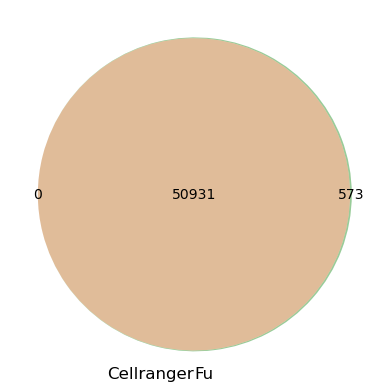

In [7]:
# get intersection of barcodes with reference
venn2([set(adata.obs_names.tolist()), set(ref.obs_names.tolist())], set_labels = ["Cellranger", "Fu"])

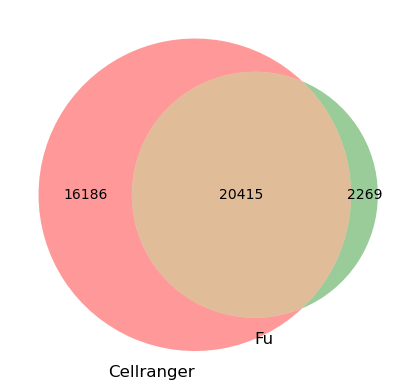

In [8]:
# get intersection of genes with reference
venn2([set(adata.var_names.tolist()), set(ref.var_names.tolist())], set_labels = ["Cellranger", "Fu"])

### subset to get only cells & genes present in cellranger, salmon and Fu

In [9]:
# load salmon data
X = io.mmread("../data/salmon_norm_counts.mtx")
alevin = ad.AnnData(X=X.transpose().tocsr())

cell_meta = pd.read_csv("../data/salmon_metadata.csv")

with open("../data/salmon_gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# add metadata
alevin.obs = cell_meta
alevin.obs.index = alevin.obs['barcode']
alevin.var.index = gene_names

# add raw count data
alevin.layers["counts"] = io.mmread("../data/salmon_raw_counts.mtx").transpose().tocsr()

Text(0.5, 1.0, 'Intersection of barcodes')

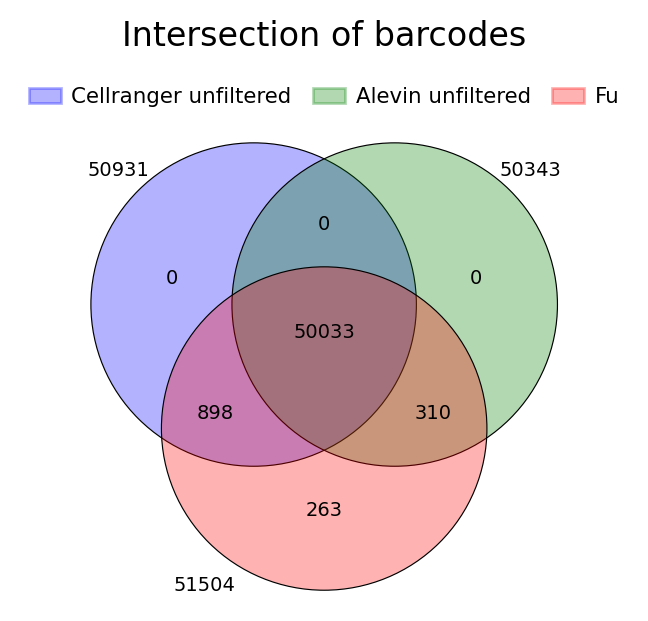

In [10]:
# intersection of barcodes
venny4py({"Cellranger unfiltered": set(adata.obs_names.tolist()),
         "Alevin unfiltered": set(alevin.obs_names.tolist()),
         "Fu": set(ref.obs_names.tolist())})
plt.title("Intersection of barcodes")

Text(0.5, 1.0, 'Intersection of genes')

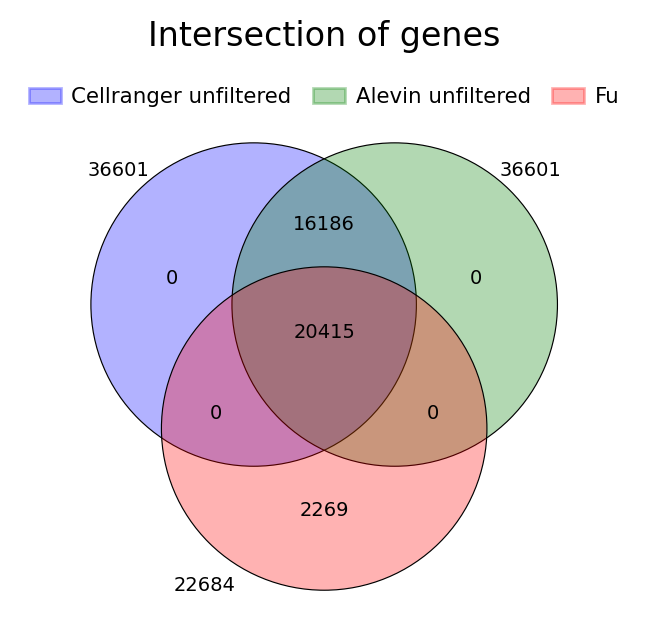

In [11]:
# intersection of genes
venny4py({"Cellranger unfiltered": set(adata.var_names.tolist()),
         "Alevin unfiltered": set(alevin.var_names.tolist()),
         "Fu": set(ref.var_names.tolist())})
plt.title("Intersection of genes")

In [12]:
# get subset present in all 3 
cell_subset =  list(set(alevin.obs_names.tolist()) & set(ref.obs_names.tolist()) & set(adata.obs_names.tolist()))
gene_subset =  list(set(alevin.var_names.tolist()) & set(ref.var_names.tolist()) & set(adata.var_names.tolist()))

# reduce to subset
adata = adata[cell_subset, gene_subset]
ref = ref[cell_subset, gene_subset]

### preprocessing

In [13]:
# get highly variable features from reference
variable_mask = [ref.var['highly_variable'][gene] for gene in adata.var_names.tolist()]
adata.var['highly_variable'] = variable_mask

In [14]:
adata.var['highly_variable'].sum()

5507

In [15]:
# scale data
sc.pp.scale(adata, max_value=10)

In [16]:
# get PCA from reference
adata.obsm["X_pca"] = ref[adata.obs_names, adata.var_names].obsm["X_pca"] 

In [17]:
# neighbors
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)

In [18]:
# get clusters from reference
adata.obs["groups"] = ref.obs["groups"]

In [19]:
# assign groups to clusters

clusters = pd.Series(index=adata.obs.index)

# assign cluster based on group values
clusters[adata.obs['groups'].isin(["c01", "c02"])] = 'TRM'
clusters[adata.obs['groups'].isin(["c03", "c04", "c07"])] = 'Teff/TRM'
clusters[adata.obs['groups'].isin(["c05"])] = 'nonTRM'
clusters[adata.obs['groups'].isin(["c06", "c08"])] = 'Tfh'
clusters[adata.obs['groups'].isin(["c10"])] = 'Treg'

# add to adata
adata.obs['cluster'] = clusters

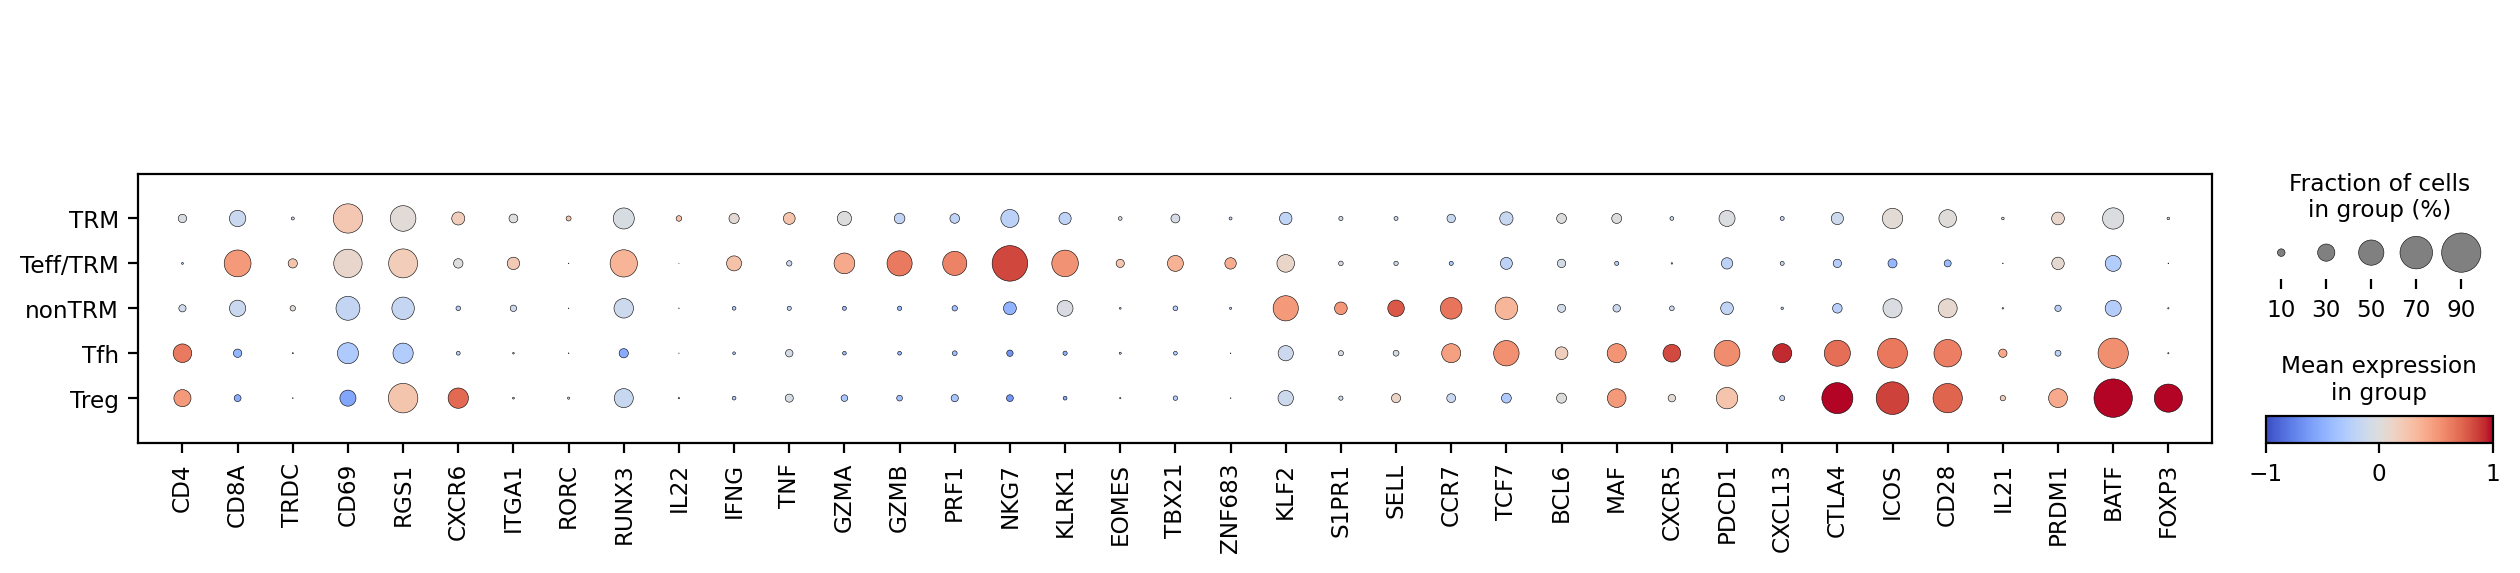

In [20]:
# check gene expression
markers = ["CD4", "CD8A", "TRDC", "CD69", "RGS1", "CXCR6", "ITGA1", "RORC", "RUNX3", "IL22", "IFNG", "TNF", 
           "GZMA", "GZMB", "PRF1", "NKG7", "KLRK1", "EOMES", "TBX21", "ZNF683", "KLF2", "S1PR1", "SELL", 
           "CCR7", "TCF7", "BCL6", "MAF", "CXCR5", "PDCD1", "CXCL13", "CTLA4", "ICOS", "CD28", "IL21", 
           "PRDM1", "BATF", "FOXP3"]

sc.pl.dotplot(adata, markers, groupby='cluster', vmin=-1, vmax=1, vcenter=0, cmap="coolwarm",
             categories_order = ["TRM", "Teff/TRM", "nonTRM", "Tfh", "Treg"])

In [21]:
# add UMAP coordinates from reference
adata.obsm["X_umap"] = ref.obsm["X_umap"]

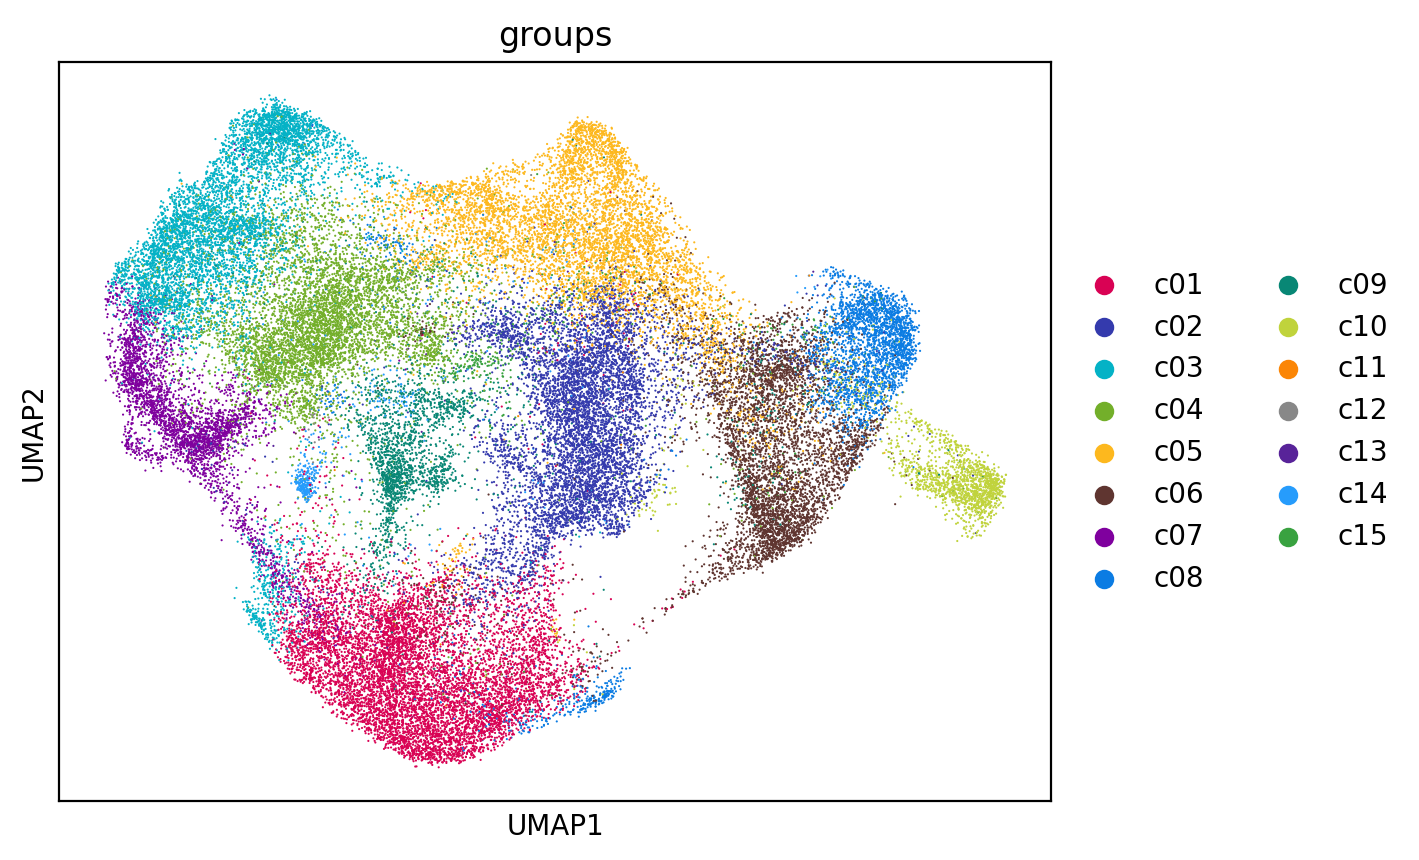

In [22]:
# plot UMAP
sc.pl.umap(adata, color="groups", dimensions=(0,1), palette=umap_colors)

In [23]:
# save
adata.write_h5ad(filename="../data/fu_cellranger.h5ad")